In [556]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyodbc
import sys
import urllib
from sqlalchemy import create_engine
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

%matplotlib inline

In [566]:
df_sales2019 = pd.read_csv("../data/p_store_order2019.csv", dtype={"orderno":str, "dcamount":int, "oriamount":int, "tamount":int})
df_sales2018 = pd.read_csv("../data/p_store_order2018.csv", dtype={"orderno":str, "dcamount":int, "oriamount":int, "tamount":int})

In [567]:
df_sales2019.head(2)

,orderno,branch,saledate,saletime,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,20190314,1411,1,0,2300,2300
1,201904160001,BK0008,20190416,1224,1,0,3000,3000


In [568]:
# change setdate and saletime to datetime
def convert_dates(df):
    """
    converts saledate and saletime columns into one datetime datatype column
    
    Paremeters
    ==========
    df: Pandas DataFrame
    
    Returns
    =======
    df: Pandas Dataframe
        returns dataframe with new saledate column and drops old columns
    
    """
    df["saledate"] = df["saledate"].astype("str") + df["saletime"].astype("str").str.zfill(4)
    df["saledate"] = pd.to_datetime(df["saledate"], format='%Y%m%d%H%M')
    df.drop("saletime", axis=1, inplace=True)
    return df

In [569]:
# new dataframes with converted datetimes
df2019 = convert_dates(df_sales2019)
df2018 = convert_dates(df_sales2018)
df2019.head(1)

,orderno,branch,saledate,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,2019-03-14 14:11:00,1,0,2300,2300


In [570]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521588 entries, 0 to 1521587
Data columns (total 7 columns):
orderno       1521588 non-null object
branch        1521588 non-null object
saledate      1521588 non-null datetime64[ns]
chk_cancel    1521588 non-null int64
dcamount      1521588 non-null int64
oriamount     1521588 non-null int64
tamount       1521588 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 81.3+ MB


In [598]:
def store_dataframe(df, interval):
    """
    Dataframe with datetime interval as rows and each store's tamount as columns.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    interval: str
        Label of the interval used to aggregate datetimes
        
    Returns
    =======
    Pandas DataFrame
        New aggregated DataFrame of the all stores and time interval
    """
    store_df = df.set_index('saledate')[["branch", "tamount"]]
    store_df = store_df.groupby("branch").resample(interval, label='right').sum()
    store_df = store_df["tamount"].unstack(level=0)#.astype('Int64')
    return store_df[1:] # drop first row (previous year sales)


In [599]:
# get df with all branches as column broken down to months
store_df = store_dataframe(df2019, "M")
store_df.head(5)

branch,BK0008,BK0010,BK0014,BK0016,BK0017,BK0018,BK0019,BK0020,BK0021,BK0022,...,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003,bk0009,bk0011,bk0016,bk0023,bk0026
saledate,,,,,,,,,,,,,,,,,,,,,
2019-01-31,NaN,27616850.0,32120850.0,9476600.0,17817090.0,49449650.0,73158360.0,52265470.0,6054100.0,23664400.0,...,NaN,NaN,19933100.0,53670950.0,50362100.0,15570500.0,49746750.0,NaN,NaN,NaN
2019-02-28,NaN,20143750.0,26576150.0,7328300.0,13183010.0,42068350.0,60155120.0,44193120.0,3955050.0,20222450.0,...,NaN,NaN,14902650.0,42085450.0,42372520.0,9675100.0,40029250.0,NaN,NaN,NaN
2019-03-31,2300.0,23794500.0,34445750.0,12136200.0,18500140.0,50182400.0,75233910.0,66544330.0,5251800.0,24355050.0,...,NaN,NaN,17144000.0,63679500.0,52472420.0,31303700.0,46045450.0,NaN,NaN,NaN
2019-04-30,3000.0,25440300.0,38331200.0,13343800.0,21088580.0,52066800.0,73853400.0,74502530.0,6195200.0,27481550.0,...,NaN,NaN,20517000.0,69185050.0,57099560.0,39107450.0,48026550.0,NaN,NaN,NaN
2019-05-31,0.0,26134550.0,35974150.0,13066400.0,17538520.0,48597450.0,70697040.0,74445240.0,5552100.0,29433750.0,...,NaN,NaN,17937350.0,77582900.0,59159590.0,34896550.0,44018650.0,NaN,NaN,NaN


In [272]:
store_df.head()

branch,BK0008,BK0010,BK0014,BK0016,BK0017,BK0018,BK0019,BK0020,BK0021,BK0022,...,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003,bk0009,bk0011,bk0016,bk0023,bk0026
saledate,,,,,,,,,,,,,,,,,,,,,
2019-01-31,NaN,27616850.0,32120850.0,9476600.0,17817090.0,49449650.0,73158360.0,52265470.0,6054100.0,23664400.0,...,NaN,NaN,19933100.0,53670950.0,50362100.0,15570500.0,49746750.0,NaN,NaN,NaN
2019-02-28,NaN,20143750.0,26576150.0,7328300.0,13183010.0,42068350.0,60155120.0,44193120.0,3955050.0,20222450.0,...,NaN,NaN,14902650.0,42085450.0,42372520.0,9675100.0,40029250.0,NaN,NaN,NaN
2019-03-31,2300.0,23794500.0,34445750.0,12136200.0,18500140.0,50182400.0,75233910.0,66544330.0,5251800.0,24355050.0,...,NaN,NaN,17144000.0,63679500.0,52472420.0,31303700.0,46045450.0,NaN,NaN,NaN
2019-04-30,3000.0,25440300.0,38331200.0,13343800.0,21088580.0,52066800.0,73853400.0,74502530.0,6195200.0,27481550.0,...,NaN,NaN,20517000.0,69185050.0,57099560.0,39107450.0,48026550.0,NaN,NaN,NaN
2019-05-31,0.0,26134550.0,35974150.0,13066400.0,17538520.0,48597450.0,70697040.0,74445240.0,5552100.0,29433750.0,...,NaN,NaN,17937350.0,77582900.0,59159590.0,34896550.0,44018650.0,NaN,NaN,NaN


In [477]:
def saledate_decomp(df):
    """
    Decompose the saledate column into sub-components of time delta.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    
    Returns
    =======
    Pandas DataFrame
        New dataframe with decomposed salesdate columns appended   
    """
    
    df_new = df[["branch", "saledate", "tamount"]].copy()
    df_new["year"] = df_new["saledate"].dt.year
    df_new["month"] = df_new["saledate"].dt.month
    df_new["day"] = df_new["saledate"].dt.day
    df_new["hour"] = df_new["saledate"].dt.hour
    df_new["minute"] = df_new["saledate"].dt.minute
    df_new["day_of_week"] = df_new["saledate"].dt.dayofweek
    value = df_new["year"].value_counts().idxmax()
    del df_new["saledate"]
    return df_new[df_new["year"]==value] # exclude pre-year dates

In [329]:
test = saledate_decomp(df2019)
test.head()

,branch,tamount,year,month,day,hour,minute,day_of_week
0,BK0008,2300.0,2019,3,14,14,11,3
1,BK0008,3000.0,2019,4,16,12,24,1
2,BK0008,4600.0,2019,6,11,17,56,1
3,BK0008,4000.0,2019,6,24,17,9,0
4,BK0008,5100.0,2019,6,24,17,13,0


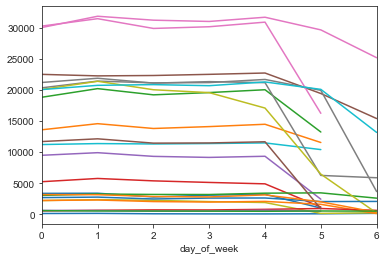

In [335]:
test.groupby(["branch", "day_of_week"]).count()["tamount"].unstack(level=0).plot(legend=False)

In [314]:
test_mean = test.groupby(["branch","day_of_week"]).sum()
test_mean.reset_index(inplace=True)
#test_mean
fig = px.line(test_mean, x="day_of_week", y="tamount", color="branch", hover_name="branch")#, line_shape="spline", render_mode="svg")
fig.show()


In [522]:
def weekly_average_series(df, STORE_CODE):
    """
    Calculates the average for each day of the week for one store. 
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    STORE_CODE: str
        Store ID number
    
    Returns
    =======
    Pandas Series
        Average for each day of the week
    
    """
    # get daily sales of store
    store_series = store_dataframe(df2019, "D")[STORE_CODE]
    # get count of each dayofweek in year
    c = Counter(store_series.index.dayofweek)
    count = np.array([x[1] for x in sorted(c.items())]) # convert to allow numpy broadcasting
    weekly_average = store_series.groupby(store_series.index.weekday).sum() / count
    return weekly_average

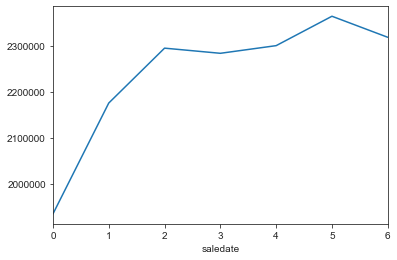

In [523]:
wk = weekly_average_series(df2019, "BK0019")
wk.plot()

In [603]:
def weekly_average_dataframe(df):
    """
    Combines series from weekly_average_series() into one dataframe.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    
    Returns
    =======
    Pandas DataFrame
        Average for each day of the week
    
    """
    branches = df["branch"].unique() # prepare branch columns
    d = {branch:weekly_average_series(df, branch) for branch in branches} # dictionary of series
    weekly_df = pd.DataFrame.from_dict(d)
    return weekly_df

In [606]:
test = weekly_average_dataframe(df2019)
test.astype("int64")

,BK0008,bk0009,BK0010,bk0011,BK0014,BK0016,bk0016,BK0017,BK0018,BK0019,...,bk0023,BK0024,BK0025,bk0026,BK0027,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003
saledate,,,,,,,,,,,,,,,,,,,,,
0,15140,13827,0,945770,0,0,161720,0,1104572,1934733,...,30664,0,8806,98313,212666,57219,0,0,0,588179
1,11088,1132242,909951,1376411,1253250,369771,195283,720871,1533688,2175744,...,267484,274047,168246,93598,227593,45898,58359,780455,2497766,1924774
2,14298,1177607,969297,1416119,1380430,394618,203606,725062,1513648,2295072,...,292654,285437,169362,85057,252044,54885,42709,818156,2646724,2023391
3,9688,1134811,936802,1460990,1317250,381542,185490,712264,1550224,2283881,...,273378,235280,155636,87140,245137,62072,34497,814623,2586514,2017265
4,6261,1127697,962629,1429077,1326230,373638,193804,713899,1550393,2300521,...,249513,261485,145784,80033,253372,62372,39534,765525,2614631,2038346
5,5901,994776,996383,1504214,1391305,350488,198086,730341,1606054,2364433,...,281126,276775,165281,81960,272853,67267,47531,793259,2694807,2011809
6,11876,385533,821498,1467371,948363,90661,158650,204208,1412880,2318684,...,176185,98980,119197,97958,282135,82545,34392,60560,1369692,612750
